# Лабораторная работа №2
Выполнила Фонград Анастасия КИ21-16/1б

Цель работы: знакомство с теоретическими основами задачи классификации
объектов, формирование навыков решения задачи бинарной классификации с
помощью языка программирования Python.
Задачи:
Выполнение практической работы предполагает решение следующий
задач:
1. Предварительная обработка исходных данных
2. Обучение базовых моделей классификации
3. Подбор оптимальных параметров моделей классификации
4. Оценка качества построенных моделей на тестовой выборке

Вариант 2

In [1]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from matplotlib.ticker import MultipleLocator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from csv import DictWriter
from imblearn.over_sampling import RandomOverSampler, KMeansSMOTE

In [2]:
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

In [3]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229292 entries, 0 to 229291
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    229292 non-null  int64  
 1   Gender                229292 non-null  object 
 2   Age                   229292 non-null  int64  
 3   Driving_License       229292 non-null  int64  
 4   Region_Code           229292 non-null  float64
 5   Previously_Insured    229292 non-null  int64  
 6   Vehicle_Age           229292 non-null  object 
 7   Vehicle_Damage        229292 non-null  object 
 8   Annual_Premium        229292 non-null  float64
 9   Policy_Sales_Channel  229292 non-null  float64
 10  Vintage               229292 non-null  int64  
 11  Response              229292 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 21.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152862 entries, 0 to 152861
Data columns (total 

In [4]:
number_of_elements = 20000  # Количество элементов
train_data = train_data.sample(n=number_of_elements,
                                         replace=False)  # replace: следует ли использовать повторения при выборке.
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 82005 to 173661
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    20000 non-null  int64  
 1   Gender                20000 non-null  object 
 2   Age                   20000 non-null  int64  
 3   Driving_License       20000 non-null  int64  
 4   Region_Code           20000 non-null  float64
 5   Previously_Insured    20000 non-null  int64  
 6   Vehicle_Age           20000 non-null  object 
 7   Vehicle_Damage        20000 non-null  object 
 8   Annual_Premium        20000 non-null  float64
 9   Policy_Sales_Channel  20000 non-null  float64
 10  Vintage               20000 non-null  int64  
 11  Response              20000 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 2.0+ MB


Из info видно, что ни в одном столбце нет пустых значений. Выполним деление на числовые и категориальные признаки

In [5]:
df_cat = ["Gender", "Vehicle_Age", "Vehicle_Damage"]
df_num = ["Age", "Driving_License", "Previously_Insured", "Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]
df_all = df_num + df_cat
result_col = "Response"

Построим парный график для всех переменных таблицы, чтобы определить корреляции между ними

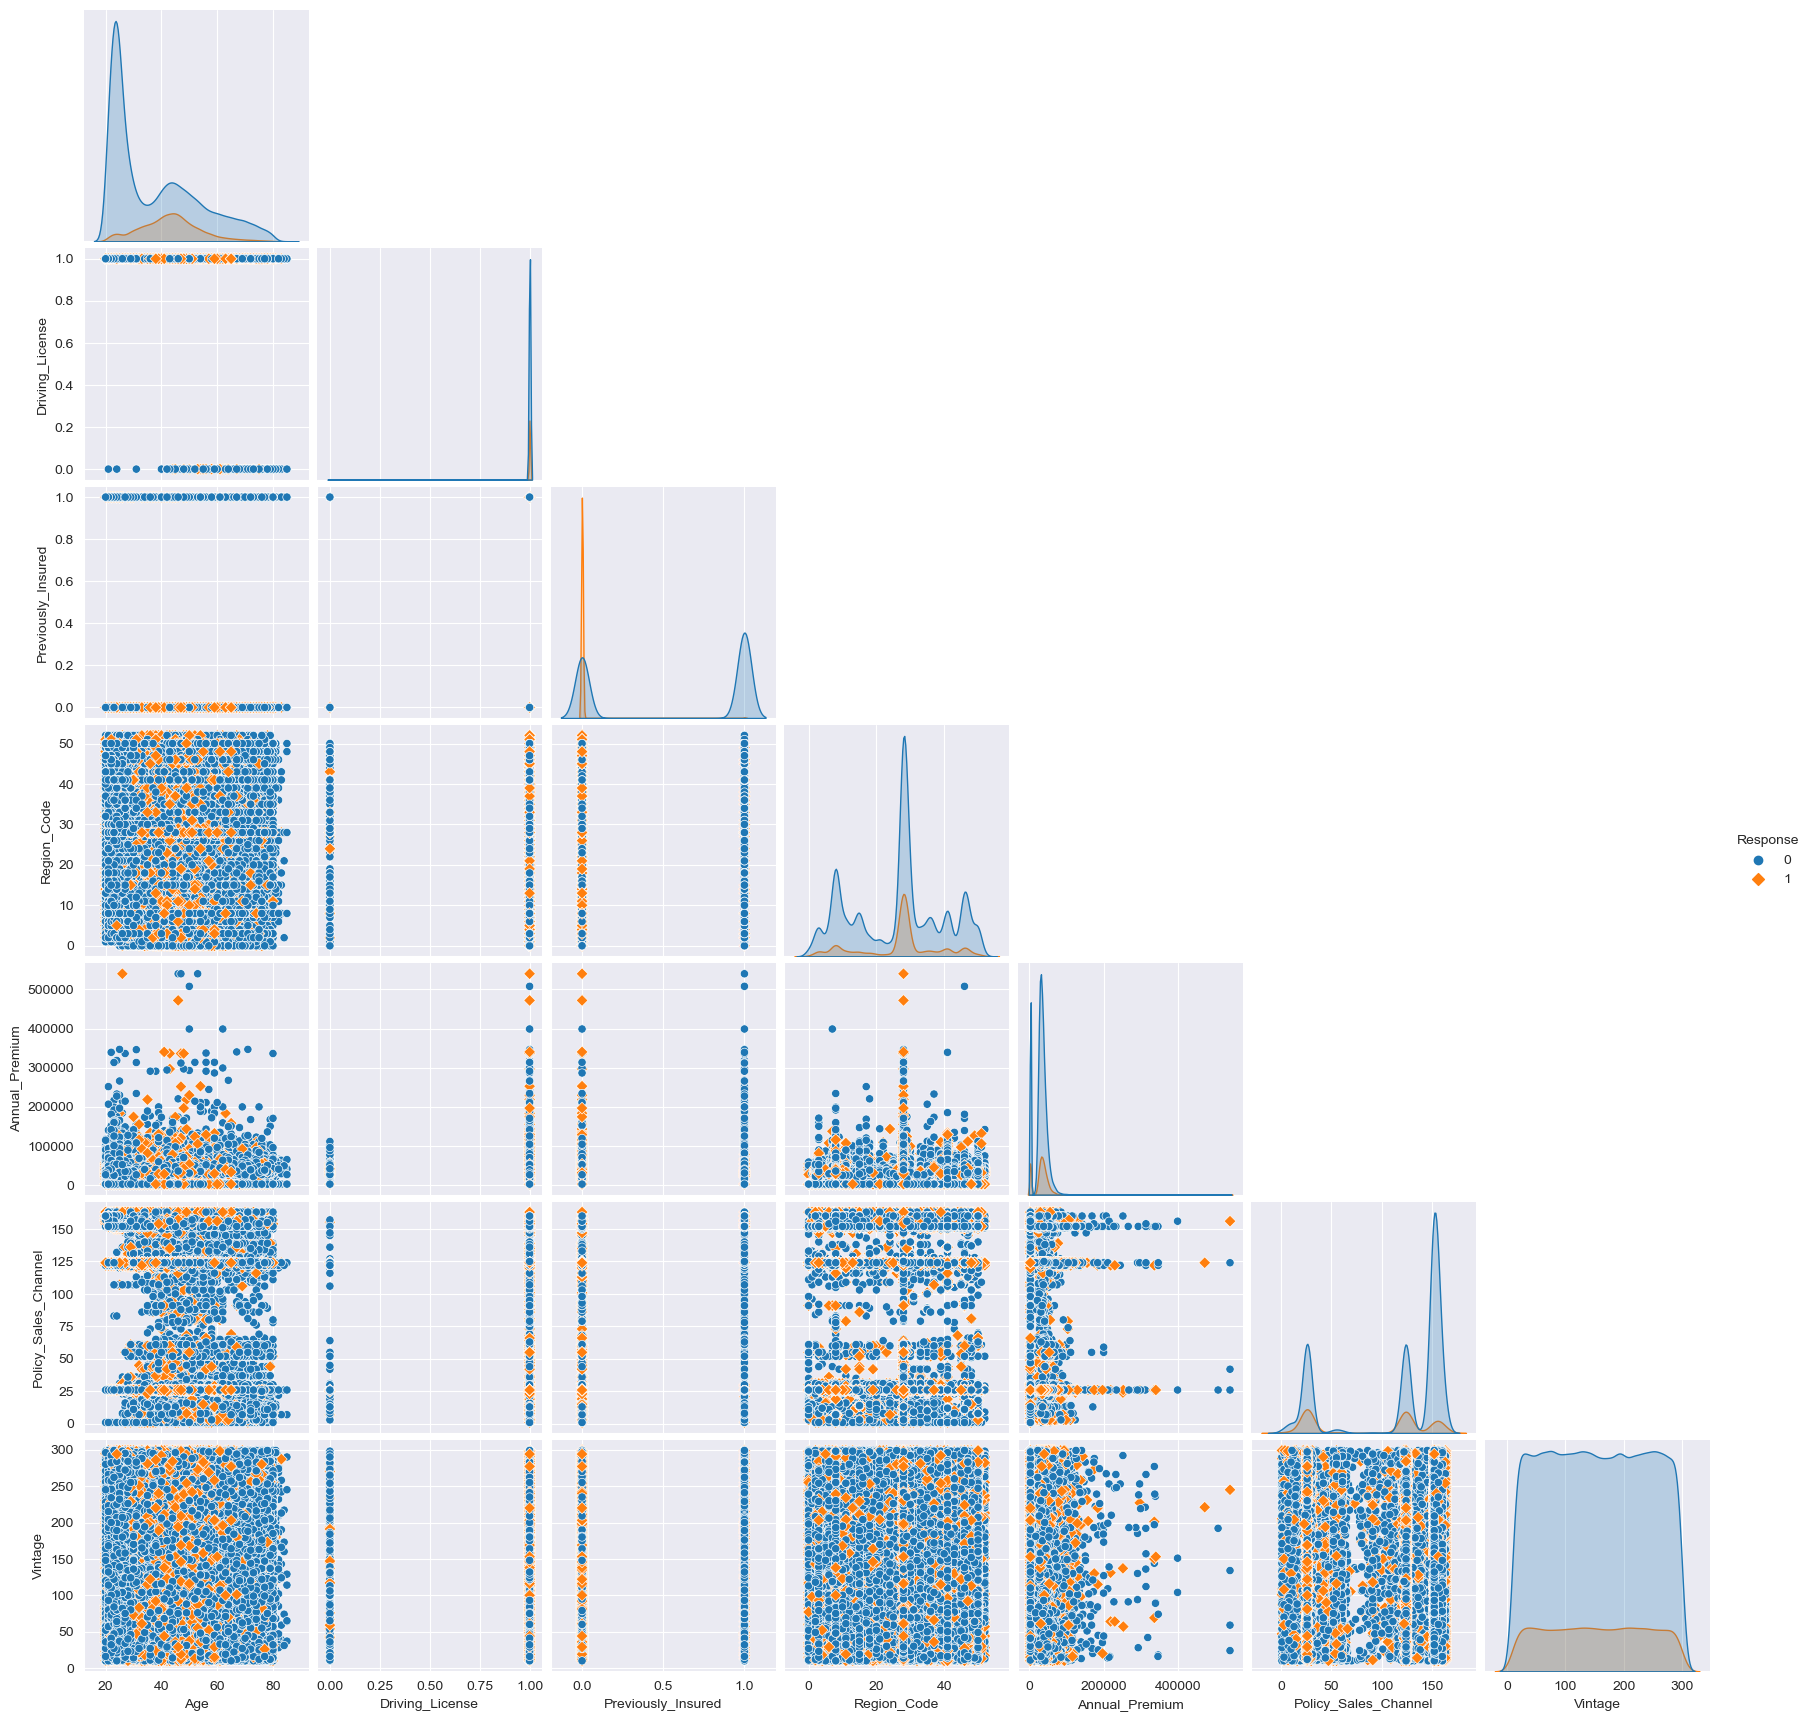

In [5]:
sns.pairplot(train_data[df_all + [result_col]], hue=result_col, corner=True, markers=["o", "D"])

In [6]:
[print(col, train_data[col].unique()) for col in df_cat]

Gender ['Female' 'Male']
Vehicle_Age ['1-2 Year' '< 1 Year' '> 2 Years']
Vehicle_Damage ['No' 'Yes']


[None, None, None]

In [7]:
print(train_data[df_num].describe())

                Age  Driving_License  Previously_Insured   Region_Code  \
count  20000.000000     20000.000000        20000.000000  20000.000000   
mean      38.310550         0.998550            0.491650     26.553400   
std       15.170113         0.038052            0.499943     13.221319   
min       20.000000         0.000000            0.000000      0.000000   
25%       25.000000         1.000000            0.000000     15.000000   
50%       35.500000         1.000000            0.000000     28.000000   
75%       48.000000         1.000000            1.000000     36.000000   
max       82.000000         1.000000            1.000000     52.000000   

       Annual_Premium  Policy_Sales_Channel       Vintage  
count    20000.000000          20000.000000  20000.000000  
mean     30895.998600            112.537300    154.131850  
std      16691.563504             54.066135     84.017066  
min       2630.000000              1.000000     10.000000  
25%      24777.750000            

Произведём кодирование категориальных признаков

In [8]:
le = LabelEncoder()
for column in df_cat:
    train_data[column] = le.fit_transform(train_data[column])
    test_data[column] = le.fit_transform(test_data[column])
    train_data[column] = train_data[column].astype("category")
    test_data[column] = test_data[column].astype("category")
    print(column, train_data[column].unique())

Gender [0, 1]
Categories (2, int64): [0, 1]
Vehicle_Age [0, 1, 2]
Categories (3, int64): [0, 1, 2]
Vehicle_Damage [0, 1]
Categories (2, int64): [0, 1]


Произведём нормирование всех числовых признаков

In [9]:
train_data.drop("id", axis=1, inplace=True)
test_ids = test_data["id"]
test_data.drop("id", axis=1, inplace=True)
scaler = MinMaxScaler()
train_data[df_num] = scaler.fit_transform(train_data[df_num])
test_data[df_num] = scaler.fit_transform(test_data[df_num])
train_data.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.295331,0.998550,0.510642,0.491650,0.097962,0.688502,0.498726,0.162300
std,0.244679,0.038052,0.254256,0.499943,0.057849,0.333742,0.290716,0.368735
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.080645,1.000000,0.288462,0.000000,0.076758,0.172840,0.245675,0.000000
50%,0.250000,1.000000,0.538462,0.000000,0.101231,0.925926,0.498270,0.000000
75%,0.451613,1.000000,0.692308,1.000000,0.128236,0.932099,0.750865,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Отбор информативных признаков

In [10]:
x = train_data[df_all]
y = train_data[result_col]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)
masks = scoring = tuple()
n_features = 5

In [11]:
def find_features(method):
    """
    Определяет наиболее значимые признаки модели
    @:param method: способ выбора признаков
    @:return: имена значимых признаков
    """
    values = method.fit(x, y)
    selected_features_names = values.get_feature_names_out()
    print("Top 5 features: ", end="")
    print(selected_features_names)
    return selected_features_names

### Метод фильтрации

In [12]:
skb = SelectKBest(chi2, k=n_features)
selected_names_1 = find_features(skb)

Top 5 features: ['Age' 'Previously_Insured' 'Policy_Sales_Channel' 'Vehicle_Age'
 'Vehicle_Damage']


### Метод обёртки

In [13]:
sfs = SequentialFeatureSelector(GaussianNB(), n_features_to_select=n_features, n_jobs=-1, scoring="roc_auc")
# Тестируем с помощью наивного байевского классификатора
selected_names_2 = find_features(sfs)

Top 5 features: ['Age' 'Driving_License' 'Previously_Insured' 'Region_Code'
 'Vehicle_Damage']


### Встроенные методы

In [14]:
selector = SelectFromModel(LinearRegression())
selected_names_3 = find_features(selector)

Top 5 features: ['Age' 'Driving_License' 'Previously_Insured' 'Annual_Premium'
 'Policy_Sales_Channel' 'Vehicle_Damage']


### Сравнение результатов

In [15]:
selected_dict = {
    "filtration": skb,
    "wrapper": sfs,
    "built-in methods": selector,
}

Подсчёт score для изначального фрейма

In [21]:
model = GaussianNB().fit(x_train, y_train)
masks += ([True for _ in range(x_train.shape[1])],)
scoring += (roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]),)
print("Default score (ROC-AUC): " + str(round(scoring[-1], 3)))

Default score (ROC-AUC): 0.863


In [22]:
for selector_name, selector in selected_dict.items():
    model = GaussianNB().fit(selector.transform(x_train), y_train)
    masks += (selector.get_support(),)
    scoring = (roc_auc_score(y_test, model.predict_proba(selector.transform(x_test))[:, 1]),)
    print(selector_name + " score (ROC-AUC): " + str(round(scoring[-1], 3)))

filtration score (ROC-AUC): 0.861
wrapper score (ROC-AUC): 0.87
built-in methods score (ROC-AUC): 0.862


Можно увидеть, что 2 метод выбора значимых признаков дал наилучший результат
### Удаление незначимых признаков

In [23]:
selected_features = selected_names_2
train_data = train_data.loc[:, np.append(selected_features, result_col)]
test_data = test_data.loc[:, selected_features]
df_all = selected_features

x = train_data[df_all]
y = train_data[result_col]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 82005 to 173661
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 20000 non-null  float64 
 1   Driving_License     20000 non-null  float64 
 2   Previously_Insured  20000 non-null  float64 
 3   Region_Code         20000 non-null  float64 
 4   Vehicle_Damage      20000 non-null  category
 5   Response            20000 non-null  int64   
dtypes: category(1), float64(4), int64(1)
memory usage: 1.4 MB


## Сэмплирование данных
Из графика ниже видно, что изначальное разделение данных не является сбалансированным

In [24]:
def build_response_graph():
    plt.pie(y.value_counts(), labels=(0, 1))
    plt.title("Распределение значения response в выборке")
    plt.legend((0, 1))
    plt.show()

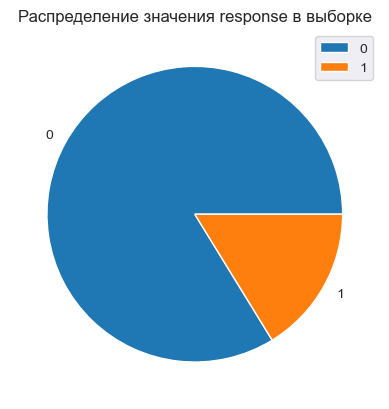

In [25]:
build_response_graph()

In [27]:
sampling = {"default": (x, y),
            "over sampling": RandomOverSampler().fit_resample(x, y),
            "KMeansSMOTE": KMeansSMOTE(cluster_balance_threshold=0.3).fit_resample(x, y),
            "under sampling": RandomUnderSampler().fit_resample(x, y)
}
scoring = []
print("Score (ROC-AUC):")
for key, value in sampling.items():
    model = GridSearchCV(LinearRegression(), param_grid={}, scoring="roc_auc").fit(value[0], value[1])
    scoring += (model.score(value[0], value[1]),)
    print(key + ": " + str(round(scoring[-1], 3)))
    print(value[1].value_counts())

Score (ROC-AUC):
default: 0.822
0    16754
1     3246
Name: Response, dtype: int64
over sampling: 0.823
0    16754
1    16754
Name: Response, dtype: int64
KMeansSMOTE: 0.924
1    16755
0    16754
Name: Response, dtype: int64
under sampling: 0.818
0    3246
1    3246
Name: Response, dtype: int64


In [28]:
max_index = scoring.index(max(scoring[1:]))
x, y = list(sampling.values())[max_index]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)
print(f"Using model: {list(sampling.keys())[max_index]}")

Using model: KMeansSMOTE


Теперь значения response распределены более равномерно

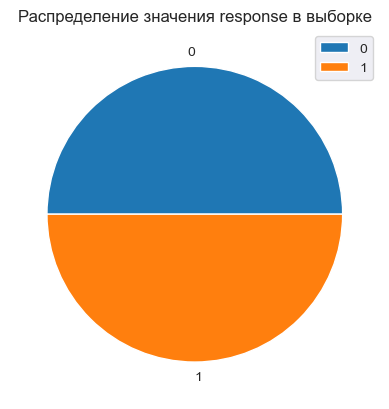

In [29]:
build_response_graph()

## Построение моделей

In [30]:
def create_train_model(clf, param_grid={}) -> GridSearchCV:
    """
    Строит модель на основе данных
    :param clf: вид используемой модели
    :param param_grid: параметры для теста моделей
    :return:
    """
    print("Started creation")
    """Создать и обучить модель с подбором параметров."""
    new_model = GridSearchCV(clf, param_grid, n_jobs=-1, scoring="roc_auc").fit(x_train, y_train)
    if param_grid:
        print(new_model.best_estimator_)
    print("Score (ROC_AUC): " + str(round(new_model.score(x_test, y_test), 3)))
    return new_model


### Логистическая регрессия

In [31]:
param_grid = {
    "penalty": ["l1", "l2"],
    "C": np.logspace(-4, 4, 100),
}
lg = create_train_model(LogisticRegression(), param_grid)

Started creation
LogisticRegression(C=0.0041320124001153384)
Score (ROC_AUC): 0.923


### Метод KNN

In [32]:
param_grid = {
    "n_neighbors": range(10, 30),
    "weights": ["uniform", "distance"],
    "metric": ["manhattan", "euclidean"]
}
knc = create_train_model(KNeighborsClassifier(), param_grid)

Started creation
KNeighborsClassifier(metric='manhattan', n_neighbors=15)
Score (ROC_AUC): 0.951


### Наивный байесовский классификатор

In [33]:
gnb = create_train_model(GaussianNB())

Started creation
Score (ROC_AUC): 0.938


### Линейный дискриминантный анализ

In [34]:
lda = create_train_model(LinearDiscriminantAnalysis())

Started creation
Score (ROC_AUC): 0.922


### Квадратичный дискриминантный анализ

In [35]:
qda = create_train_model(QuadraticDiscriminantAnalysis())

Started creation
Score (ROC_AUC): 0.937


### Метод опорных векторов

In [36]:
svc = create_train_model(SVC(probability=True))

Started creation
Score (ROC_AUC): 0.929


### Построение ROC кривых и столбчатой диаграммы score

In [41]:
models = (lg, knc, gnb, lda, qda, svc)
names = scoring = probs = tuple()
for model in models:
    names += (model.best_estimator_.__class__.__name__,)
    scoring += (round(model.score(x_test, y_test), 3),)
    probs += (model.predict_proba(x_test)[:, 1],)

In [42]:
def plot_roc_curves(ax):
    """
    Строит ROC кривые для всех моделей
    :param ax: ось, на которой строим график
    """
    labels = tuple()
    for index, prob in enumerate(probs):
        fpr, tpr, _ = roc_curve(y_test, prob)
        area = round(auc(fpr, tpr), 3)
        labels += (names[index] + f" ({area=})",)
        axes[0].plot(fpr, tpr)
    ax.plot((-0.01, 1.01), (-0.01, 1.01), color="navy", linestyle="--")
    ax.set_title("ROC curves")
    ax.set_xlim((-0.01, 1.01))
    ax.set_ylim((-0.01, 1.01))
    ax.set_xlabel("False positive rate", labelpad=15)
    ax.set_ylabel("True positive rate", labelpad=15)
    ax.legend(loc="lower right", labels=labels)

In [45]:
def plot_bar_graph(ax):
    """
    Строит столбчатую диаграмму для score моделей
    :param ax: ось, на которой строим график
    """
    ax.bar(names, scoring)
    ax.set_title("Scoring (ROC-AUC)")
    ax.tick_params("x", labelrotation=90)
    ax.set_ylim((0.5, 1))
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.01))
    for rect, score in zip(ax.patches, scoring):
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.01, score, ha="center")
    ax.set_xlabel("Model", labelpad=15)
    ax.set_ylabel("Score", labelpad=15)

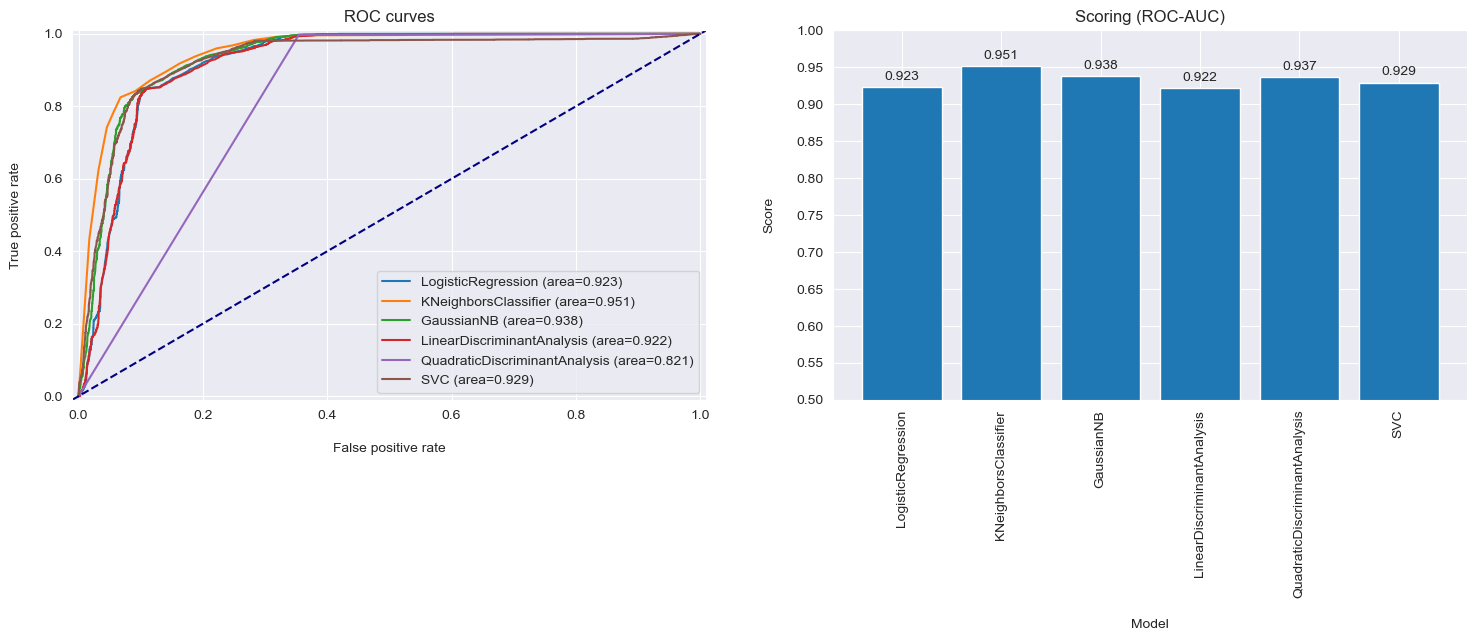

In [44]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(18)
plot_roc_curves(axes[0])
plot_bar_graph(axes[1])
plt.show()

In [46]:
best_model = models[scoring.index(max(scoring))]
print("В результате анализа была выбрана следующая модель: " + str(best_model.best_estimator_))

В результате анализа была выбрана следующая модель: KNeighborsClassifier(metric='manhattan', n_neighbors=15)


## Работа с тестовой выборкой

In [47]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152862 entries, 0 to 152861
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   Age                 152862 non-null  float64 
 1   Driving_License     152862 non-null  float64 
 2   Previously_Insured  152862 non-null  float64 
 3   Region_Code         152862 non-null  float64 
 4   Vehicle_Damage      152862 non-null  category
dtypes: category(1), float64(4)
memory usage: 4.8 MB


Предсказанные значения для тестовой выборки были сохранены в отдельный csv файл

In [48]:
with open("../data/submission.csv", "w", encoding="utf-8") as csv:
    writer = DictWriter(
        csv, delimiter=",", lineterminator="\r",
        fieldnames=["PassengerId", "Survived"]
    )
    writer.writeheader()

    test_data = test_data.loc[:, selected_features]
    prediction = best_model.predict(test_data)

    for i, predict in enumerate(prediction):
        writer.writerow({"PassengerId": test_ids[i], "Survived": predict})